# Hackathon Challenge : Tweet Classification
<img src="./twitter.png" width="150" height="150" align="right"/>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/axelsirota/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
train = pd.read_csv("train.csv")
train.shape

(27481, 3)

In [4]:
train.head(3)

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative


<AxesSubplot:>

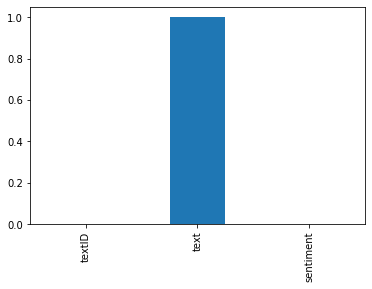

In [5]:
train.isnull().sum().plot(kind='bar')

In [6]:
test = pd.read_csv("test.csv")
test.shape

(3534, 3)

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


<AxesSubplot:xlabel='sentiment', ylabel='count'>

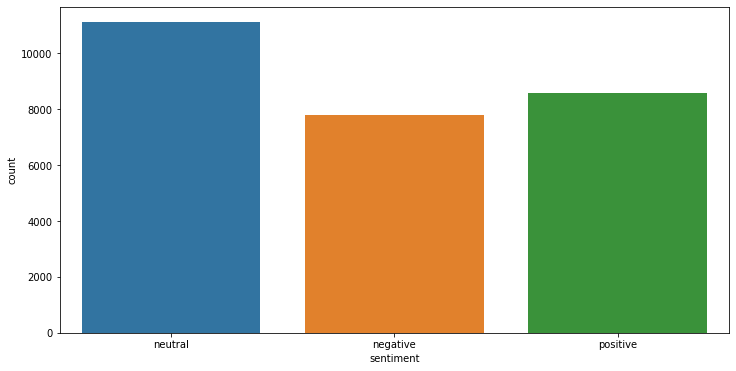

In [8]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=train)

In [9]:
test.sentiment.value_counts().max() / test.sentiment.value_counts().sum()

0.4046406338426712

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob, Word

sia = SentimentIntensityAnalyzer()

def correct_and_lemmatize(tweet):
    blob_tweet = TextBlob(tweet)
    return ' '.join([word.lemmatize() for word in blob_tweet.words])

def process_df(df):
    df.dropna(inplace=True)
#     df['text'] = df['text'].encode("ascii", "ignore")
    df['text'] = df['text'].astype(str)
    df['corrected_text'] = df.text.apply(correct_and_lemmatize)
    df['text_blob_sentiment'] = df.corrected_text.apply(lambda x: TextBlob(x).sentiment.polarity)
    compound= []
    neg = []
    neu = []
    pos = []
    for tweet in df['corrected_text']:
        sent = sia.polarity_scores(tweet)
        compound.append(sent['compound'])
        neg.append(sent['neg'])
        neu.append(sent['neu'])
        pos.append(sent['pos'])

    df['compound'] = compound
    df['neg'] = neg
    df['neu'] = neu
    df['pos'] = pos
    return df

In [12]:
train = process_df(train)

In [13]:
train.head()

,textID,text,sentiment,corrected_text,text_blob_sentiment,compound,neg,neu,pos
0,cb774db0d1,"I`d have responded, if I were going",neutral,I d have responded if I were going,0.0,0.0000,0.000,1.000,0.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,Sooo SAD I will miss you here in San Diego,-0.5,-0.6633,0.437,0.563,0.0
2,088c60f138,my boss is bullying me...,negative,my bos is bullying me,0.0,-0.5994,0.494,0.506,0.0
3,9642c003ef,what interview! leave me alone,negative,what interview leave me alone,0.0,-0.2960,0.516,0.484,0.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,Sons of why couldn t they put them on the rele...,0.0,0.0000,0.000,1.000,0.0


<AxesSubplot:title={'center':'neg'}, xlabel='sentiment'>

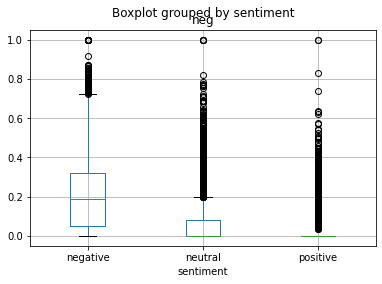

In [14]:
train.boxplot(column='neg', by='sentiment')

In [15]:
test = process_df(test)

In [16]:
test.head(2)

,textID,text,sentiment,corrected_text,text_blob_sentiment,compound,neg,neu,pos
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day http twitpic.com/67ezh,0.000000,0.0000,0.0,1.000,0.000
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,Shanghai is also really exciting precisely sky...,0.466667,0.7501,0.0,0.652,0.348


In [17]:
y_train = train['sentiment']
X_train = train[['corrected_text','compound', 'neg', 'neu', 'pos', 'text_blob_sentiment']]

In [18]:
y_test = test['sentiment']
X_test = test[['corrected_text','compound', 'neg', 'neu', 'pos', 'text_blob_sentiment']]

In [19]:
vect = TfidfVectorizer(min_df=5, strip_accents='unicode', stop_words='english')
X_train_dtm = vect.fit_transform(X_train.corrected_text)
X_test_dtm = vect.transform(X_test.corrected_text)

In [20]:
# Cast other feature columns to float and convert to a sparse matrix.
extra = sp.sparse.csr_matrix(X_train.drop('corrected_text', axis=1).astype(float))
extra.shape
# Combine sparse matrices.
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape, X_train_dtm.shape

((27480, 4029), (27480, 4024))

In [21]:
# Repeat for testing set.
extra = sp.sparse.csr_matrix(X_test.drop('corrected_text', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(3534, 4029)

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_dtm_extra.toarray())
X_test_final = scaler.transform(X_test_dtm_extra.toarray())

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB   
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# clf = RandomForestClassifier(n_estimators=70,max_depth=50)
clf = LogisticRegression(max_iter=1000, C=10000000)
clf.fit(X_train_final,y_train)

y_pred =clf.predict(X_test_final)
print(metrics.accuracy_score(y_pred, y_test))

0.6669496321448783


In [32]:
confusion_matrix(y_test, y_pred)

array([[657, 303,  41],
       [261, 922, 247],
       [ 62, 263, 778]])

Text(0.5, 1.0, 'Confusion Matrix')

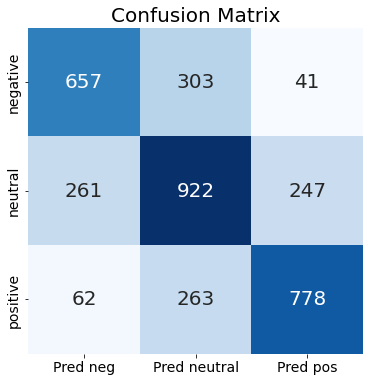

In [33]:
conmat = np.array(confusion_matrix(y_test, y_pred))
confusion = pd.DataFrame(conmat, index=['negative', 'neutral', 'positive'],\
                     columns=['Pred neg', 'Pred neutral', 'Pred pos'])

plt.figure(figsize = (6,6))
heat = sns.heatmap(confusion, annot=True, annot_kws={"size": 20},cmap='Blues',fmt='g', cbar=False)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.title("Confusion Matrix", fontsize=20)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.67      0.66      0.66      1001
     neutral       0.62      0.64      0.63      1430
    positive       0.73      0.71      0.72      1103

    accuracy                           0.67      3534
   macro avg       0.67      0.67      0.67      3534
weighted avg       0.67      0.67      0.67      3534

